In [1]:
# OpenPOM analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from numpy.linalg import norm

In [2]:
# MCF imports
from molecule_validation import is_odorant, score_molecule


############################################################
#                     Initialize MCFs                      #
############################################################

Filter                                        Min        Max
------------------------------------------------------------
LogP                                         0.06       4.91
Molecular Weight                           100.12     282.46
HBAB + HBD                                   0.00       5.00
TPSA                                         0.00      63.32
Rotatable Bonds                              0.00      11.00
NO2 Groups                                   0.00       0.00
Heteroatoms                                  0.00       4.00
Aromatic Rings                               0.00       1.00
Atom Count                                   0.00      20.00
Triple Bonds                                 0.00       0.00
Oxygen Chain Length                          0.00       1.00

#####################

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# from submodels.openpom.functions import fragance_propabilities_from_smiles

#from numpy.linalg import norm

#TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
#TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

In [4]:

def calculate_score(mol, is_vanilla):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol)[0] + score_molecule(mol).all() + is_vanilla)/3

def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return int(is_odorant(mol)[0]) + score_molecule(mol).all()

def hard_filter(mol):
    return int(int(is_odorant(mol)[0]) * score_molecule(mol).all())

In [5]:
def explicit_H_filter(smiles: str) -> bool:
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        if atom.GetNumExplicitHs() > 1:
            return False  
    return True



def generate_scores(df):
    df['score'] = df.apply(
        lambda x: calculate_score(
            Chem.MolFromSmiles(x.nonStereoSMILES), 
            x.vanilla
            ), axis=1)
    return df

def cosine_similarity(vec1,vec2):
    return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))


In [6]:
hist_df=pd.DataFrame()
hist_dfv=pd.DataFrame()

In [7]:
# Read Offline Molecules
df = pd.read_csv("openpomdata.csv").drop("descriptors",axis=1)

In [8]:
len(df[df["vanilla"]==1])

111

In [9]:
# Find Vanillin (Both "COc1cc(C=O)ccc1O" and "COC1=C(C=CC(=C1)C=O)O" are valid SMILES strings for vanillin)
df[df["nonStereoSMILES"]=="COc1cc(C=O)ccc1O"]

,nonStereoSMILES,alcoholic,aldehydic,alliaceous,almond,amber,animal,anisic,apple,apricot,...,tropical,vanilla,vegetable,vetiver,violet,warm,waxy,weedy,winey,woody
64,COc1cc(C=O)ccc1O,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [10]:
len(df.keys()[1:])

138

In [11]:
vanilla_index = df[df["nonStereoSMILES"]=="COc1cc(C=O)ccc1O"].index[0]

In [12]:
def custom_function(row):
    # Example: Accessing individual values from the row using row[column_name]
    vanilla_corr = df.iloc[vanilla_index][1:].to_numpy()  # Assuming this is the pre-calculated vanilla correlation vector
    scent_values = row[1:].to_numpy()  # Get the scent values from the row (excluding the first column)
    assert len(row[1:])==138, f"{df.keys()}"
    
    # Apply cosine similarity between the row's scent values and the vanilla correlation vector
    return cosine_similarity(scent_values, vanilla_corr)  #  

# Apply the custom function to each row
df['reward'] = df.apply(custom_function, axis=1)

<Axes: >

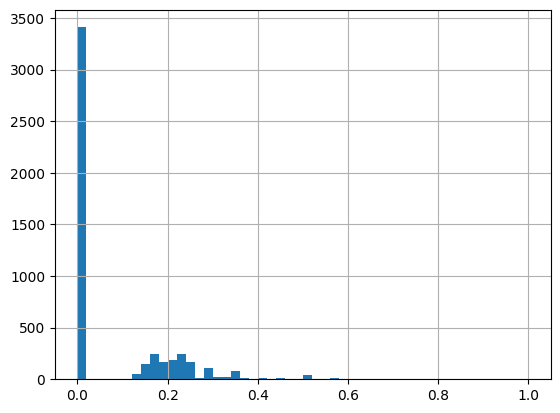

In [13]:
df["reward"].hist(bins=50)

In [14]:
hist_df["cTrueLabel"] = df["reward"]
hist_dfv["cTrueLabel"] = df[df["vanilla"]==1]["reward"]


In [15]:
# Read Offline Molecules
df_openpom = pd.read_csv("OpenPOM_probs.csv")

In [16]:
len(df_openpom),len(df)

(4782, 4983)

In [17]:
ind = []
for i in df[df["vanilla"]==1]["nonStereoSMILES"]:
    ind.append(df_openpom[df_openpom["nonStereoSMILES"]==i].index[0])

In [18]:
list(df_openpom.iloc[ind]["nonStereoSMILES"])==list(df[df["vanilla"]==1]["nonStereoSMILES"])

True

In [19]:
vanilla_index = df_openpom[df_openpom["nonStereoSMILES"]=="COc1cc(C=O)ccc1O"].index[0]
vanilla_index

62

In [20]:
def custom_function(row):
    # Example: Accessing individual values from the row using row[column_name]
    vanilla_corr = df_openpom.iloc[vanilla_index][1:].to_numpy()  # Assuming this is the pre-calculated vanilla correlation vector
    scent_values = row[1:].to_numpy()  # Get the scent values from the row (excluding the first column)
    
    assert len(row[1:])==138, f"{df.keys()} \n \n {df_openpom.keys()}"
    # Apply cosine similarity between the row's scent values and the vanilla correlation vector
    return cosine_similarity(scent_values, vanilla_corr)  #  

# Apply the custom function to each row
df_openpom['reward'] = df_openpom.apply(custom_function, axis=1)

<Axes: >

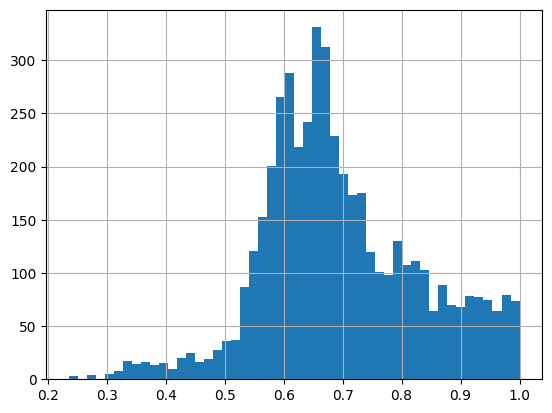

In [21]:
df_openpom["reward"].hist(bins=50)

In [22]:
df_openpom.iloc[ind]["reward"]

4       0.988414
26      0.975963
32      0.931831
62      1.000000
65      0.998580
          ...   
4482    0.918295
4532    0.991080
4675    0.956425
4706    0.987876
4757    0.936418
Name: reward, Length: 111, dtype: float64

In [ ]:
hist_df["cOpenpom"] = df_openpom["reward"]
hist_dfv["cOpenpom"] = list(df_openpom.iloc[ind]["reward"].reset_index(drop=True))

In [24]:
df.keys()[1:-1]

Index(['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
       'anisic', 'apple', 'apricot', 'aromatic',
       ...
       'tropical', 'vanilla', 'vegetable', 'vetiver', 'violet', 'warm', 'waxy',
       'weedy', 'winey', 'woody'],
      dtype='object', length=138)

In [25]:
def custom_function(row):
    # Example: Accessing individual values from the row using row[column_name]
    vanilla_corr = df_openpom.iloc[vanilla_index][1:-1].to_numpy()  # Assuming this is the pre-calculated vanilla correlation vector
    scent_values = row[1:-1].to_numpy()  # Get the scent values from the row (excluding the first column)
    assert len(scent_values)==138, f"{len(df.keys())} \n \n {len(df_openpom.keys())}"
    
    # Apply cosine similarity between the row's scent values and the vanilla correlation vector
    return cosine_similarity(scent_values, vanilla_corr)  #  

# Apply the custom function to each row
df['rewardcomb'] = df.apply(custom_function, axis=1)
    

<Axes: >

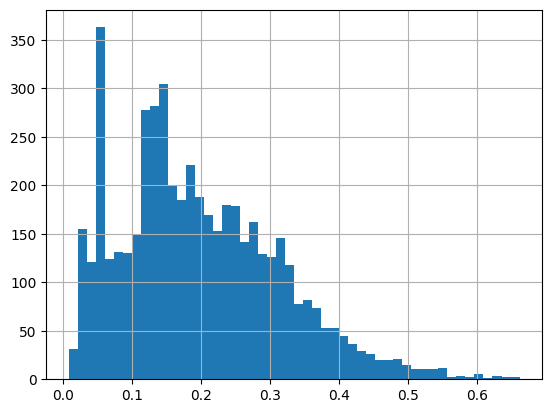

In [26]:
df["rewardcomb"].hist(bins=50)

In [27]:
hist_df["cMixLabel"] = df["rewardcomb"]
hist_dfv["cMixLabel"] = df[df["vanilla"]==1]["rewardcomb"]

In [28]:
vanilla_index = df[df["nonStereoSMILES"]=="COc1cc(C=O)ccc1O"].index[0]
def custom_function(row):
    # Example: Accessing individual values from the row using row[column_name]
    vanilla_corr = df.iloc[vanilla_index][1:-2].to_numpy()  # Assuming this is the pre-calculated vanilla correlation vector
    scent_values = row[1:-1].to_numpy()  # Get the scent values from the row (excluding the first column)
    assert len(scent_values)==138, f"{df.keys()} \n \n {df_openpom.keys()}"
    assert len(vanilla_corr)==138, f"{df.keys()} \n \n {df_openpom.keys()}"
    # Apply cosine similarity between the row's scent values and the vanilla correlation vector
    return cosine_similarity(scent_values, vanilla_corr)  #  

# Apply the custom function to each row
df_openpom['rewardcomb'] = df_openpom.apply(custom_function, axis=1)
    

<Axes: >

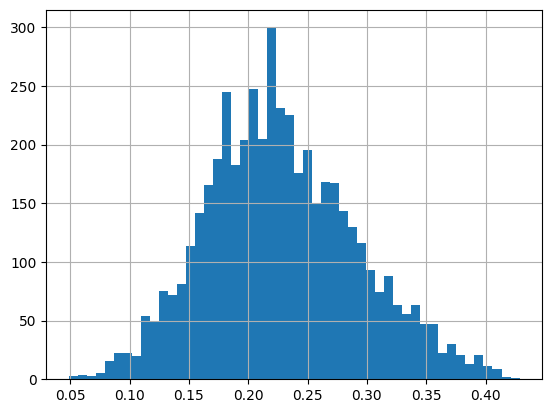

In [29]:
df_openpom['rewardcomb'].hist(bins=50)

In [30]:
hist_df["cMixedOpenpom"] = df_openpom["rewardcomb"]
hist_dfv["cMixedOpenpom"] = list(df_openpom.iloc[ind]["rewardcomb"].reset_index(drop=True))

In [31]:
hist_dfv.keys()

Index(['cTrueLabel', 'cOpenpom', 'cMixLabel', 'cMixedOpenpom'], dtype='object')

In [32]:
len(hist_dfv["cTrueLabel"].dropna()),len(hist_dfv["cOpenpom"].dropna()),len(hist_dfv["cMixLabel"].dropna()),len(hist_dfv["cMixedOpenpom"].dropna())

(111, 6, 111, 111)

Index(['cTrueLabel', 'cOpenpom', 'cMixLabel', 'cMixedOpenpom'], dtype='object')
0
1
2
3


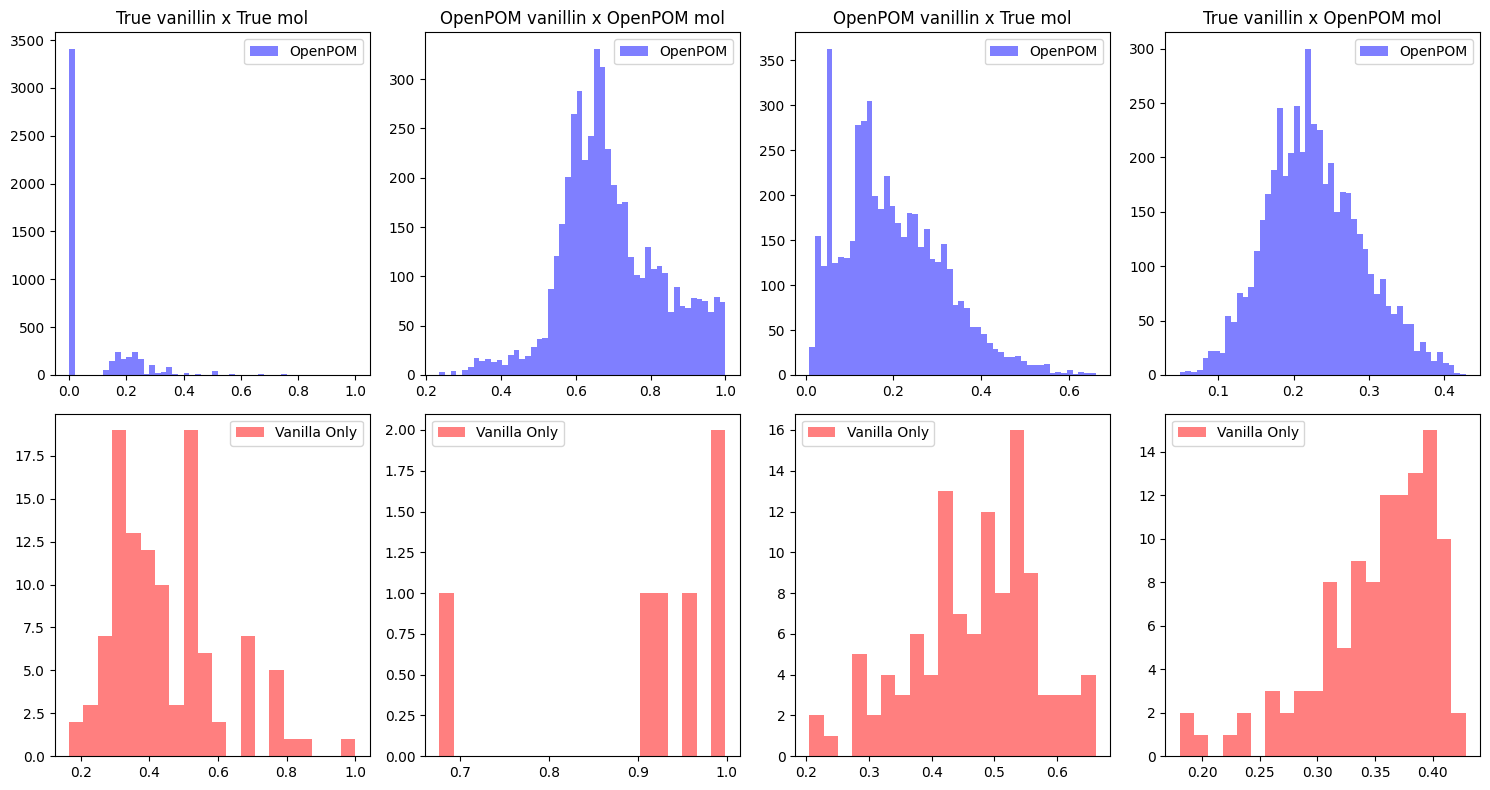

In [34]:
import matplotlib.pyplot as plt

# Assume df1 and df2 are your two DataFrames
cols_to_plot = hist_df.keys()  # Since they have the same column names
print(cols_to_plot)
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # 6 plots: 2 rows, 3 columns
titles = ["True vanillin x True mol", "OpenPOM vanillin x OpenPOM mol", "OpenPOM vanillin x True mol", "True vanillin x OpenPOM mol"]
axes = axes.flatten()  # Flatten to a 1D array for easy iteration

for idx, col in enumerate(cols_to_plot):
    print(idx)
    ax1 = axes[idx]
    ax2 = axes[idx+4]
    #ax.set_yscale("log")
    ax1.hist(hist_df[col], bins=50, alpha=0.5, label='OpenPOM', color='blue')
    ax2.hist(hist_dfv[col], bins=20, alpha=0.5, label='Vanilla Only', color='red')
    
    ax1.set_title(titles[idx])
    ax1.legend()
    ax2.legend()

# Make layout tight so labels/titles don't overlap
plt.tight_layout()
plt.show()


In [41]:
# Read Offline Molecules
df = pd.read_csv("openpomdata.csv").drop("descriptors",axis=1)

# Simplify the requirements for the Molecule Building environment 

# Drop all odorless molecules (They often contain weird elements)
df =  df[df['odorless'] == False]

# Drop all molecules with more than one explicit hydrogen atom 
df = df[df["nonStereoSMILES"].apply(explicit_H_filter)].copy() 

# Reset index since some indexes have been dropped (1,3,7,...) to (1,2,3,...)
df = df.reset_index(drop=True)
print(len(df))

# Calculate reward function values 

# Scent corrolation 
scent_matrix = df[df.keys()[1:]].to_numpy()
vanilla_idx = list(df.keys()[1:]).index("vanilla")  

# compute Pearson correlation between vanilla and every other scent
vanilla_col = scent_matrix[:, vanilla_idx]
corrs = np.array([np.corrcoef(vanilla_col, scent_matrix[:, i])[0,1] for i in range(138)])
vanilla_corr_vec = np.nan_to_num(corrs)  # shape: (138,), with NaNs replaced by 0


scent_cols = df.columns[1:]
df["reward"]= df[scent_cols].apply(lambda x: cosine_similarity(x, vanilla_corr_vec), axis=1)

# Normalize to [0.1, 1.0] range (or any positive range you like)
min_r = df["reward"].min()
max_r = df["reward"].max()

# Avoid zero reward
scaled_rewards = 0.1 + 0.9 * (df["reward"] - min_r) / (max_r - min_r)
df["shift_reward"] = scaled_rewards
df = df[df["vanilla"]==1]
df = df.reset_index(drop=True) 

4782


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [42]:
# Read Offline Molecules
df2 = pd.read_csv("openpomdata.csv").drop("descriptors",axis=1)

# Simplify the requirements for the Molecule Building environment 

# Drop all odorless molecules (They often contain weird elements)
df2 =  df2[df2['odorless'] == False]

# Drop all molecules with more than one explicit hydrogen atom 
df2 = df2[df2["nonStereoSMILES"].apply(explicit_H_filter)].copy() 

# Reset index since some indexes have been dropped (1,3,7,...) to (1,2,3,...)
df2 = df2.reset_index(drop=True)
print(len(df2))

# Calculate reward function values 

# Scent corrolation 
scent_matrix = df2[df2.keys()[1:]].to_numpy()
vanilla_idx = list(df2.keys()[1:]).index("vanilla")  

# compute Pearson correlation between vanilla and every other scent
vanilla_col = scent_matrix[:, vanilla_idx]
corrs = np.array([np.corrcoef(vanilla_col, scent_matrix[:, i])[0,1] for i in range(138)])
vanilla_corr_vec = np.nan_to_num(corrs)  # shape: (138,), with NaNs replaced by 0


scent_cols = df2.columns[1:]
df2["reward"]= df2[scent_cols].apply(lambda x: cosine_similarity(x, vanilla_corr_vec), axis=1)

# Normalize to [0.1, 1.0] range (or any positive range you like)
min_r = df2["reward"].min()
max_r = df2["reward"].max()

# Avoid zero reward
scaled_rewards = 0.1 + 0.9 * (df2["reward"] - min_r) / (max_r - min_r)
df2["shift_reward"] = scaled_rewards

4782


c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


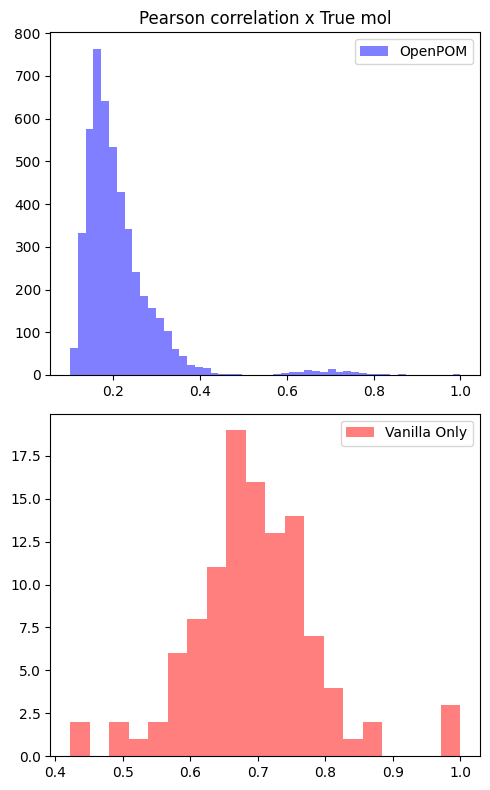

In [44]:
# Assume df1 and df2 are your two DataFrames
fig, axes = plt.subplots(2, 1, figsize=(5, 8))  # 6 plots: 2 rows, 3 columns
axes = axes.flatten()  # Flatten to a 1D array for easy iteration


ax1 = axes[0]
ax2 = axes[1]
#ax.set_yscale("log")
ax1.hist(df2["shift_reward"], bins=50, alpha=0.5, label='OpenPOM', color='blue')
ax2.hist(df["shift_reward"], bins=20, alpha=0.5, label='Vanilla Only', color='red')

ax1.set_title("Pearson correlation x True mol")
ax1.legend()
ax2.legend()

# Make layout tight so labels/titles don't overlap
plt.tight_layout()
plt.show()